## Exploring the difference between output of Neural network model and output of theoretical methods used for computing option price and it's implied volatility

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
import json

import warnings
warnings.filterwarnings("ignore") # just to remove clutter in the notebook

### <font color='Blue'> 1. Black-Scholes Model</font>

---

In [2]:
from model.pricing.utils.get_data import get_current_price, pre_processing
from model.pricing.core.black_scholes import create_dataset
from model.pricing.core.neural_network import run_nn_model

In [3]:
model_save_path = os.getcwd() + "/model/output/" + "BS_NN_model.h5"
bs_nn_model = tf.keras.models.load_model(model_save_path, compile=False)

#### <font color='Blue'>  1.1 Create datset using the below range of input parameters using Latin Hypercube sampling. </font>

|  |  |  |
|:---|:---|:---|
|      | Parameters |  Range|
|Input |Moneyness ($S_{o}$ / K) |  [0.4,1.6] |
|      |Time to Maturity | [0.2,1.1]   |
|      |Risk Free rate | [0.02,0.1] | 
|      |Volatility | [0.01,1] |
|Output|Call Price (V / K) |  [0.0,0.9]    |

---

#### <font color='Blue'> 1.2 Computes black scholes price for a test data set and then compute option price by strike. </font> 

---

In [4]:
test_data_set_size = 100000
df, st_current_price, range_of_inputs = pre_processing(test_data_set_size, "BS")
dt_test = create_dataset(df, st_current_price, range_of_inputs)
otpt_using_BS = np.array(dt_test['opt_price_by_strike'])

#### <font color='Blue'>  1.3 Using the trained BS NN model and input parameters, we computed option price ( V / K) and compared it with option price by strike ratio obtained in above step </font>

In [5]:
feature_columns = ['moneyness', 'time_to_maturity', 'risk_free_rate', 'volatility']
x_test = dt_test[feature_columns]
y_predict = bs_nn_model.predict(x_test)

 209/2958 [=>............................] - ETA: 1s

2023-02-02 13:25:11.312688: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2958/2958 [==============================] - 2s 483us/step


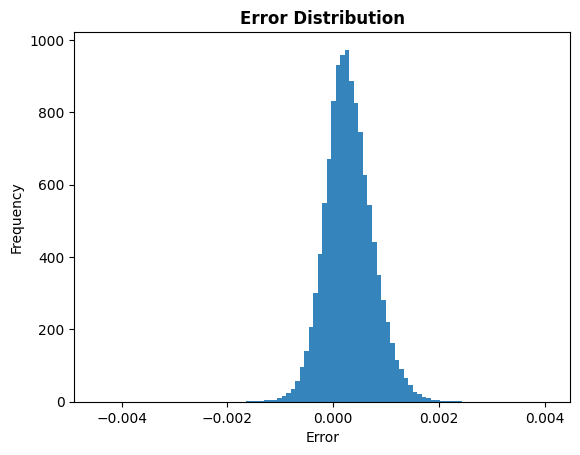

In [6]:
otpt_using_nn_model = [y[0] for y in y_predict]
diff = np.subtract(otpt_using_BS, otpt_using_nn_model)
plt.hist(diff, 100, density=1, alpha=0.9)
plt.xlabel('Error')
plt.ylabel('Frequency')
  
plt.title('Error Distribution', fontweight ="bold")
plt.show()

### <font color='Blue'>  2. Combining Heston Pricing NN model and Implied Volatility NN model </font>

---

In [7]:
from model.implied_volatility.core.heston_model_pricing import create_heston_dataset

In [8]:
heston_model_save_path = os.getcwd() + "/model/output/" + "Heston_NN_model.h5"
heston_nn_model = tf.keras.models.load_model(heston_model_save_path, compile=False)
implied_volatility_model_save_path = os.getcwd() + "/model/output/" + "Implied_volatility_NN_model.h5"
implied_volatility_nn_model = tf.keras.models.load_model(implied_volatility_model_save_path, compile=False)

#### <font color='Blue'>  1.1 Create datset using the below range of input parameters using Latin Hypercube sampling for heston pricing dataset. </font>

|  |  |  |
|:---|:---|:---|
|      | Parameters |  Range|
|Input |Moneyness ($S_{o}$ / K) |  [0.4,1.6] |
|      |Time to Maturity | [0.1,1.4]   |
|      |Risk Free rate | [0.01,0.1] | 
|      |Correlation of stochastic process of udnerlying price and volatility | [-0.95,0] |
|      |Reversion speed of volatility stochastic mean reverting process |  [0.0,2.0]     |
|      |Long average variance |  [0.0,0.5]     |
|      |Volatility of variance |  [0.0,0.5]     |
|      |Initial variance |  [0.05,0.5]     |
|Output|Call Price (V / K) |  [0.0,0.7]   |

---

#### <font color='Blue'> 2.2 Computing implied volatiity for a simulated heston price using brent method. </font> 

---

In [9]:
from model.implied_volatility.core.implied_vol import implied_volatility_call

In [10]:
otpt_heston = os.getcwd() + "/model/output/" + "Heston_model_dataset.csv"
dt_set = pd.read_csv(otpt_heston).iloc[:, 1:]
dt_set['implied_vol'] = dt_set.apply(lambda x:implied_volatility_call(x), axis=1)

In [11]:
tuned_hyper_parameter_file_name = os.getcwd() + "/model/output/" + "best_hyper_parameter.json"
with open(tuned_hyper_parameter_file_name) as f:
    df_hyper = json.load(f)

In [13]:
otpt_using_heston = np.array(dt_set['implied_vol'])

In [14]:
heston_model_save_path = os.getcwd() + "/model/output/" + "Heston_NN_model.h5"
implied_vol_model_save_path = os.getcwd() + "/model/output/" + "implied_volatility_NN_model.h5"
heston_nn_model = tf.keras.models.load_model(heston_model_save_path, compile=False)
implied_vol_nn_model = tf.keras.models.load_model(implied_vol_model_save_path, compile=False)

In [16]:
feature_columns_heston_model = ['moneyness', 'time_to_maturity', 'risk_free_rate', 'correlation', 'reversion_speed',
                       'Long_average_variance', 'vol_vol', 'initial_variance']
heston_price_using_nn_model = heston_nn_model.predict(dt_set[feature_columns_heston_model])

313/313 [==============================] - 0s 515us/step


In [32]:
dt_set['heston_price_using_NN'] = [y[0] for y in heston_price_using_nn_model]

In [33]:
dt_set.head()

,moneyness,time_to_maturity,risk_free_rate,correlation,reversion_speed,Long_average_variance,vol_vol,initial_variance,s0,strike,...,calender_days,Heston_price,opt_price_by_strike,implied_vol,heston_price_using_NN,checking_heston_price,BS_price,time_value,scaled_time_value,implied_vol_using_NN
0,0.704923,0.134975,0.089318,-0.861284,1.374675,0.477240,0.403896,0.289033,4070.560059,5774.472175,...,49,12.022537,0.002082,0.505831,-0.041600,0.002082,-240.219484,-240.219484,NaN,NaN
1,0.865403,0.427014,0.097762,-0.185793,0.729394,0.230467,0.041933,0.351214,4070.560059,4703.659001,...,156,447.653278,0.095171,0.579523,0.215044,0.095171,1011.491505,1011.491505,-1.536915,1.101817
2,0.959384,1.214109,0.033050,-0.739876,0.985806,0.425018,0.195878,0.071622,4070.560059,4242.887461,...,443,825.310628,0.194516,0.467660,0.228607,0.194516,969.951873,969.951873,-1.475753,0.567598
3,0.656980,0.673745,0.074475,-0.541343,1.735870,0.324679,0.384797,0.219602,4070.560059,6195.861959,...,246,178.063603,0.028739,0.479774,0.011617,0.028739,71.974623,71.974623,-4.455323,0.360362
4,1.209067,0.292864,0.099873,-0.155744,0.426030,0.365663,0.114322,0.405440,4070.560059,3366.694945,...,107,1001.472155,0.297464,0.639835,0.270666,0.297464,911.248259,110.336022,-3.418156,0.490467


In [22]:
from model.implied_volatility.core.implied_vol import get_time_value

In [34]:
dt_set['BS_price'] = dt_set['heston_price_using_NN'] * dt_set['strike']
dt_set['time_value'] =  dt_set.apply(lambda x: get_time_value(x), axis=1)
dt_set['scaled_time_value'] = dt_set.apply(lambda x: np.log(x['time_value'] / x['strike']), axis=1)
dt_set.dropna(inplace=True)

In [35]:
feature_columns_implied_vol_model = ['moneyness', 'time_to_maturity', 'risk_free_rate', 'scaled_time_value']
implied_vol_using_nn_model = implied_vol_nn_model.predict(dt_set[feature_columns_implied_vol_model])

272/272 [==============================] - 0s 542us/step


In [36]:
dt_set['implied_vol_using_NN'] = [y[0] for y in implied_vol_using_nn_model]